# let's see the results if we run 100x with only 1 landmark!

In [30]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [31]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give the 0th landmark"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence)  
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 2
    Y_locations = [0] * 2
    Z_locations = [0] * 2
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[hand] = landmark.x
                Y_locations[hand] = landmark.y
                Z_locations[hand] = landmark.z
                break # take only the first landmark
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [32]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = np.array(locations).tolist() 
    empty_row = np.zeros((1, 126))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [33]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
from warnings import filterwarnings
filterwarnings("ignore") 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :2] 
        Y_locations = X[:, 2:4] 
        Z_locations = X[:, 4:6]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 2:4].assign(X[:, 2:4] + mask * tf.ones_like(X[:, 2:4]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 2:4].assign(X[:, 2:4] - mask * tf.ones_like(X[:, 2:4]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :2].assign(X[:, :2] + mask * tf.ones_like(X[:, :2]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :2].assign(X[:, :2] - mask * tf.ones_like(X[:, :2]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 4:6].assign(X[:, 4:6] + mask * tf.ones_like(X[:, 4:6]) * move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 4:6].assign(X[:, 4:6] - mask * tf.ones_like(X[:, 4:6]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
    
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(**kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

In [34]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 6))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [35]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [36]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

In [37]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], []
META_RESULT_MATRIX = [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    """adds the training & validation accuracy, precision, recall, and F1 for each of the folds to a meta matrix"""
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(5): 
        # for each fold change up the dataset 
        model = make_model()

        ARMFLAPPING_TRAINING_FRAMES = np.concatenate([fold for j, fold in enumerate(ARMFLAPPING_FRAMES_SPLIT) if j != i])
        CONTROL_TRAINING_FRAMES = np.concatenate([fold for j, fold in enumerate(CONTROL_FRAMES_SPLIT) if j != i])

        ARMFLAPPING_VALIDATION_FRAMES = ARMFLAPPING_FRAMES_SPLIT[i]
        CONTROL_VALIDATION_FRAMES = CONTROL_FRAMES_SPLIT[i]

        print(ARMFLAPPING_TRAINING_FRAMES.shape, CONTROL_TRAINING_FRAMES.shape)
        print(ARMFLAPPING_VALIDATION_FRAMES.shape, CONTROL_VALIDATION_FRAMES.shape)
        
        X_test = np.concatenate([ARMFLAPPING_VALIDATION_FRAMES, CONTROL_VALIDATION_FRAMES])
        X_train = np.concatenate([ARMFLAPPING_TRAINING_FRAMES, CONTROL_TRAINING_FRAMES])
        
        y_train = np.concatenate([np.ones(len(ARMFLAPPING_TRAINING_FRAMES)), np.zeros(len(CONTROL_TRAINING_FRAMES))])
        y_test = np.concatenate([np.ones(len(ARMFLAPPING_VALIDATION_FRAMES)), np.zeros(len(CONTROL_VALIDATION_FRAMES))])

        # shuffle it to avoid 0e+00 error 
        N = np.random.permutation(X_train.shape[0])
        X_train = X_train[N]
        y_train = y_train[N]

        N= np.random.permutation(X_test.shape[0])
        X_test = X_test[N]
        y_test = y_test[N]

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 
        
        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))


        # accuracy: 0.7625 - precision: 0.7442 - recall: 0.8000 - val_loss: 0.6086 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0

        training_accuracy = history.history['accuracy'][-1]
        validation_accuracy = history.history['val_accuracy'][-1]
        training_precision = history.history['precision'][-1]
        validation_precision = history.history['val_precision'][-1]
        training_recall = history.history['recall'][-1]
        validation_recall = history.history['val_recall'][-1]
        training_f1 = 2 * training_precision * training_recall / (training_precision + training_recall)
        validation_f1 = 2 * validation_precision * validation_recall / (validation_precision + validation_recall)

        # add to meta matrix
        META_RESULT_MATRIX.append([training_accuracy, training_precision, training_recall, training_f1, validation_accuracy, validation_precision, validation_recall, validation_f1])

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [38]:
# don't shuffle  

import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 6)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y


In [39]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [40]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 6)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

    return model

In [41]:
import pickle, numpy as np
with open("one_point_folds_seeds", 'rb') as f: 
    information = pickle.load(f)

ARMFLAPPING_FRAMES, ARMFLAPPING_FILE_NAMES, CONTROL_FRAMES, CONTROL_FILE_NAMES = [np.concatenate(info) for info in information]

assert ARMFLAPPING_FILE_NAMES.shape == CONTROL_FILE_NAMES.shape
assert ARMFLAPPING_FRAMES.shape == CONTROL_FRAMES.shape

In [42]:
WRITE_DATA = False
if WRITE_DATA: 
    SEEDS = np.abs(np.array(np.random.randn(100) * 100, dtype = np.int32))
    FILES_FOR_FOLD = []
    for seed in SEEDS:
        np.random.seed(seed) # set seed 
        
        N = np.random.permutation(ARMFLAPPING_FRAMES.shape[0])
        ARMFLAPPING_FILE_NAMES = ARMFLAPPING_FILE_NAMES[N]
        CONTROL_FILE_NAMES = CONTROL_FILE_NAMES[N]

        armflapping_file_name_folds =  np.array_split(ARMFLAPPING_FILE_NAMES, 5)
        control_file_name_folds =  np.array_split(CONTROL_FILE_NAMES, 5)

        for i in range(5):
            # the ith fold is for validation, everything else is for whatever 

            armflapping_training_files = np.concatenate([fold for j, fold in enumerate(armflapping_file_name_folds) if j != i])
            control_training_files = np.concatenate([fold for j, fold in enumerate(control_file_name_folds) if j != i])

            armflapping_validation_files = armflapping_file_name_folds[i]
            control_validation_files = control_file_name_folds[i]

            FILES_FOR_FOLD.append({"train": np.concatenate([armflapping_training_files, control_training_files]).tolist(), "test": np.concatenate([armflapping_validation_files, control_validation_files]).tolist()})
    # save this and the seeds used in a pickle file 

    with open("file_names_folds.pkl", 'wb') as f: 
        pickle.dump((SEEDS.tolist(), FILES_FOR_FOLD), f)

In [43]:
if not WRITE_DATA: 
    with open("file_names_folds.pkl", 'rb') as f: 
        SEEDS, _ = pickle.load(f)

# okay so this is the same thing but for the one landmark approach

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.7038 - accuracy: 0.4875 - precision: 0.4848 - recall: 0.4000 - val_loss: 0.6719 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6573 - accuracy: 0.5875 - precision: 0.5614 - recall: 0.8000 - val_loss: 1.2703 - val_accuracy: 0.4500 - val_precision: 0.3333 - val_recall: 0.1000
Epoch 3/75
3/3 [==============================] - 0s 174ms/step - loss: 1.0188 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5500 - val_loss: 0.6516 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 174ms/step - loss: 0.6466 - accuracy: 0.5875 - precision: 0.5522 - recall: 0.9250 - val_loss: 0.6682 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 169ms/step 

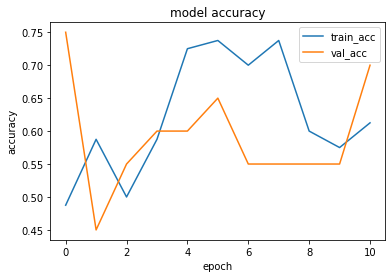

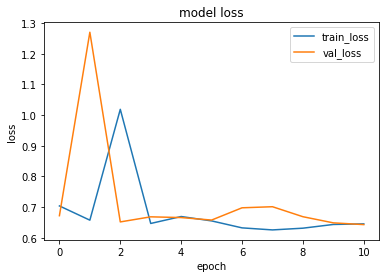

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.4988116]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.4963508]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.50269616]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.49386087]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.49169216]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.49100974]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6810 - accuracy: 0.5875 - precision: 0.5593 - recall: 0.8250 - val_loss: 0.6934 - val_accuracy: 0.5500 - val_precision: 0.5556 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6425 - accuracy: 0.6375 - precision: 0.6897 - recall: 0.5000 - val_loss: 1.1055 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.8342 - accuracy: 0.5500 - precision: 0.5270 - recall: 0.9750 - val_loss: 0.7653 - val_accuracy: 0.4500 - val_precision: 0.4615 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 216ms/step - loss: 0.6435 - accuracy: 0.7000 - precision: 0.6905 - recall: 0.7250 - val_loss: 0.7276 - val_accuracy: 0.4500 - val_precision: 0.4444 - val_recall: 0.4000
Epoch 5/75


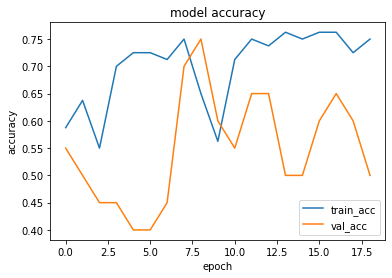

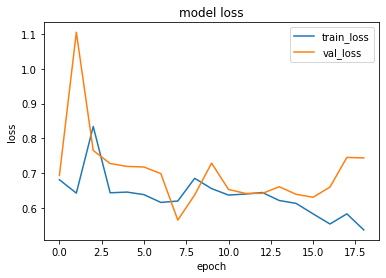

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.34080082]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.5025805]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.52496314]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.25235185]]


1it [00:00, 12372.58it/s]


prediction for video control_2.mov is [[0.24087265]]


1it [00:00, 14563.56it/s]


prediction for video control_3.mov is [[0.23240238]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 152ms/step - loss: 0.7101 - accuracy: 0.5125 - precision: 0.5122 - recall: 0.5250 - val_loss: 0.6665 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.7049 - accuracy: 0.5875 - precision: 0.5854 - recall: 0.6000 - val_loss: 0.6275 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6529 - accuracy: 0.5750 - precision: 0.5429 - recall: 0.9500 - val_loss: 0.6462 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6679 - accuracy: 0.6625 - precision: 0.6226 - recall: 0.8250 - val_loss: 0.6182 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5/75


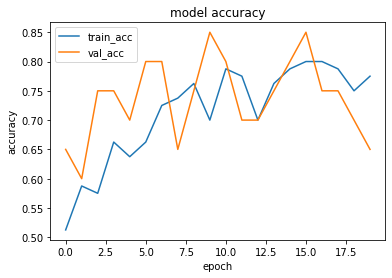

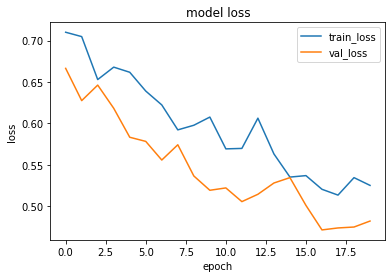

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.50412357]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.59654754]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.60715157]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.41959575]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.38507003]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.3806928]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6946 - accuracy: 0.4000 - precision: 0.3571 - recall: 0.2500 - val_loss: 0.6927 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6561 - accuracy: 0.6125 - precision: 0.5672 - recall: 0.9500 - val_loss: 0.6704 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.7829 - accuracy: 0.5375 - precision: 0.5294 - recall: 0.6750 - val_loss: 0.6442 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6679 - accuracy: 0.6000 - precision: 0.5588 - recall: 0.9500 - val_loss: 0.6760 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/75
3

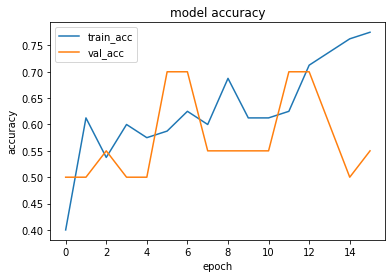

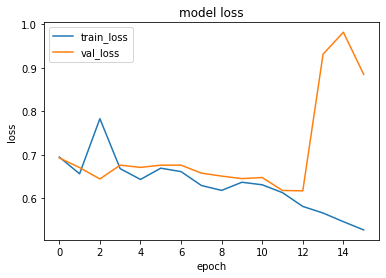

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.14280671]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.14679322]]


1it [00:00, 14217.98it/s]


prediction for video armflapping_2.mov is [[0.14663607]]


1it [00:00, 12945.38it/s]


prediction for video control_1.mov is [[0.1414156]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.14077514]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.14067498]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6861 - accuracy: 0.6125 - precision: 0.6154 - recall: 0.6000 - val_loss: 0.7049 - val_accuracy: 0.4000 - val_precision: 0.4167 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6594 - accuracy: 0.6375 - precision: 0.5873 - recall: 0.9250 - val_loss: 0.8055 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6885 - accuracy: 0.5500 - precision: 0.5286 - recall: 0.9250 - val_loss: 0.6981 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.7108 - accuracy: 0.4125 - precision: 0.2667 - recall: 0.1000 - val_loss: 0.6970 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000

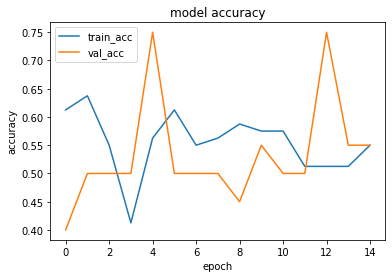

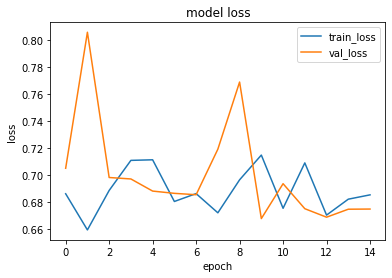

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.44426408]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.46782544]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_2.mov is [[0.45452708]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.44463697]]


1it [00:00, 8756.38it/s]


prediction for video control_2.mov is [[0.44432816]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.44458407]]


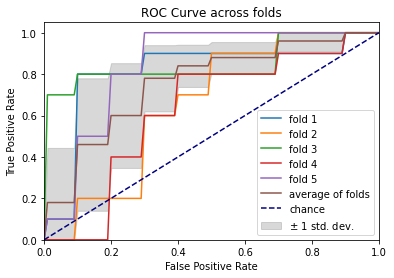

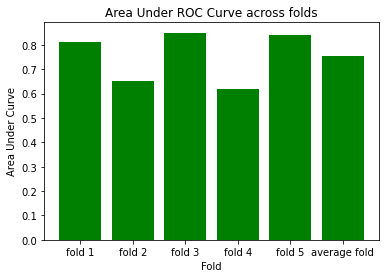

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 178ms/step - loss: 0.7681 - accuracy: 0.5750 - precision: 0.5429 - recall: 0.9500 - val_loss: 0.6843 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6906 - accuracy: 0.5250 - precision: 0.5357 - recall: 0.3750 - val_loss: 0.6986 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 0s 174ms/step - loss: 0.6720 - accuracy: 0.5250 - precision: 1.0000 - recall: 0.0500 - val_loss: 0.7389 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.1000
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6335 - accuracy: 0.7250 - precision: 0.7500 - recall: 0.6750 - val_loss: 0.7714 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 146

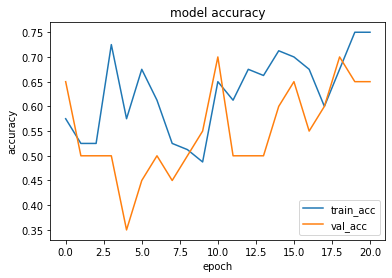

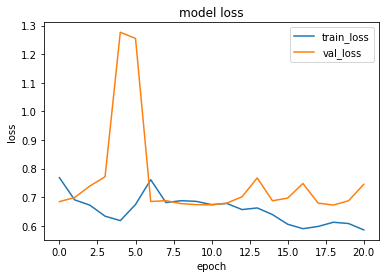

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.5123302]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.5235615]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_2.mov is [[0.5171608]]


1it [00:00, 15477.14it/s]


prediction for video control_1.mov is [[0.4898656]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.50452304]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.48984244]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 164ms/step - loss: 0.7022 - accuracy: 0.4500 - precision: 0.4333 - recall: 0.3250 - val_loss: 0.6616 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 218ms/step - loss: 0.6937 - accuracy: 0.5625 - precision: 0.5472 - recall: 0.7250 - val_loss: 0.6563 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6792 - accuracy: 0.6375 - precision: 0.6000 - recall: 0.8250 - val_loss: 0.6224 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6684 - accuracy: 0.6500 - precision: 0.6364 - recall: 0.7000 - val_loss: 0.5901 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 5/75


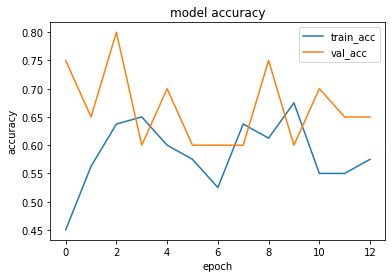

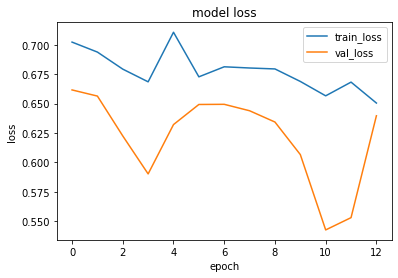

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.49802247]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_3.mov is [[0.5146931]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_2.mov is [[0.52274996]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.4846012]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.47939554]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.47748893]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6874 - accuracy: 0.5375 - precision: 0.6154 - recall: 0.2000 - val_loss: 0.6289 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.7020 - accuracy: 0.6250 - precision: 0.5833 - recall: 0.8750 - val_loss: 0.7418 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.7114 - accuracy: 0.5750 - precision: 0.8750 - recall: 0.1750 - val_loss: 0.6686 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6707 - accuracy: 0.6875 - precision: 0.7027 - recall: 0.6500 - val_loss: 0.6825 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epo

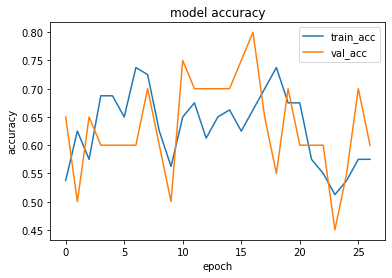

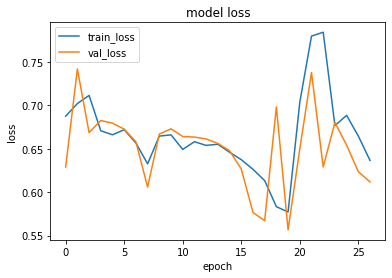

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.52519]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.5650005]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.546455]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.51896685]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.51877624]]


1it [00:00, 16320.25it/s]


prediction for video control_3.mov is [[0.5184652]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6940 - accuracy: 0.5125 - precision: 0.5122 - recall: 0.5250 - val_loss: 0.6685 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6672 - accuracy: 0.6000 - precision: 0.7500 - recall: 0.3000 - val_loss: 0.6490 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6276 - accuracy: 0.7750 - precision: 0.7750 - recall: 0.7750 - val_loss: 0.5173 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6282 - accuracy: 0.7000 - precision: 0.6905 - recall: 0.7250 - val_loss: 0.6240 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.6000
Epoch 5/75
3

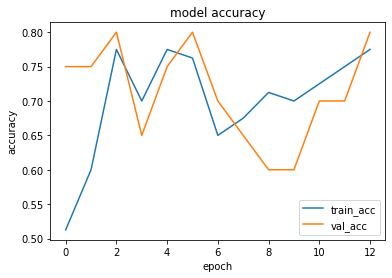

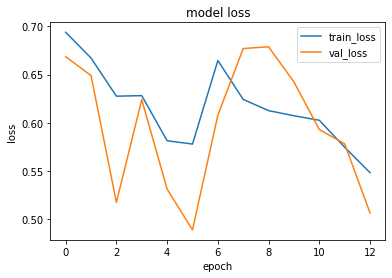

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.41686445]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.6694755]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.6620637]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.3007924]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.2742238]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.2882223]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6982 - accuracy: 0.4625 - precision: 0.4746 - recall: 0.7000 - val_loss: 0.6741 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6685 - accuracy: 0.6250 - precision: 0.5806 - recall: 0.9000 - val_loss: 0.6564 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6641 - accuracy: 0.6250 - precision: 0.7273 - recall: 0.4000 - val_loss: 0.6752 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6620 - accuracy: 0.6750 - precision: 0.7059 - recall: 0.6000 - val_loss: 0.6694 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5/75
3

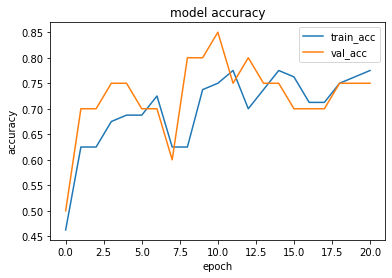

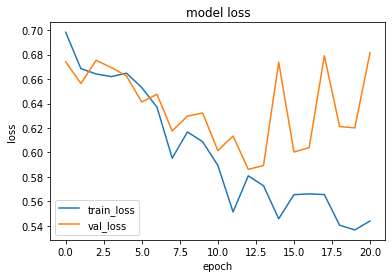

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.4975695]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_3.mov is [[0.5575976]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.590525]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.4275832]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.40304267]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.3792119]]


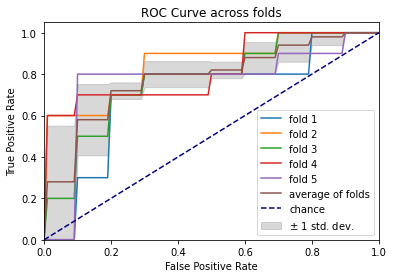

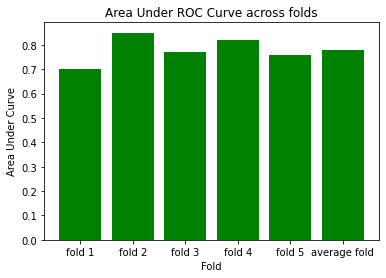

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6969 - accuracy: 0.5125 - precision: 0.5082 - recall: 0.7750 - val_loss: 0.6861 - val_accuracy: 0.5500 - val_precision: 0.5455 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6611 - accuracy: 0.6875 - precision: 0.6531 - recall: 0.8000 - val_loss: 0.6151 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6571 - accuracy: 0.6625 - precision: 0.6226 - recall: 0.8250 - val_loss: 0.6085 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6312 - accuracy: 0.7250 - precision: 0.7812 - recall: 0.6250 - val_loss: 0.6433 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 147ms/step 

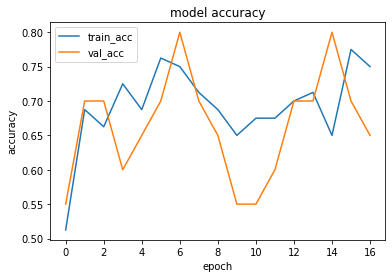

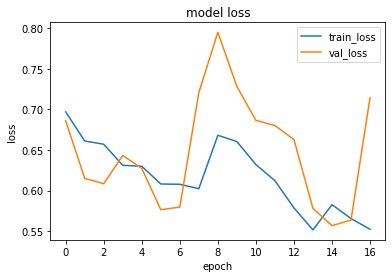

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.5093565]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.55151033]]


1it [00:00, 15477.14it/s]


prediction for video armflapping_2.mov is [[0.54519147]]


1it [00:00, 17772.47it/s]


prediction for video control_1.mov is [[0.4838735]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.47239375]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.47177842]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6885 - accuracy: 0.6375 - precision: 0.6571 - recall: 0.5750 - val_loss: 0.6680 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6696 - accuracy: 0.6375 - precision: 0.6122 - recall: 0.7500 - val_loss: 0.6128 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6125 - accuracy: 0.6750 - precision: 0.6296 - recall: 0.8500 - val_loss: 0.6460 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6278 - accuracy: 0.7375 - precision: 0.7879 - recall: 0.6500 - val_loss: 0.6410 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 5/75


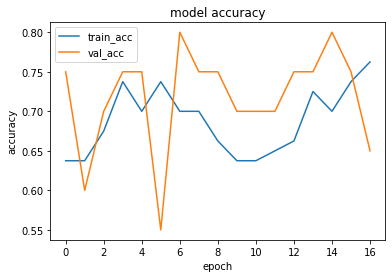

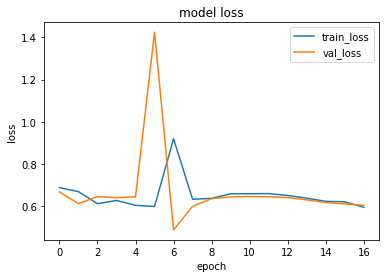

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.5236276]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.5891438]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.60078156]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.48746666]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.47912398]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.46470186]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 167ms/step - loss: 0.6843 - accuracy: 0.5125 - precision: 0.5172 - recall: 0.3750 - val_loss: 0.7947 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.7583 - accuracy: 0.5250 - precision: 0.5167 - recall: 0.7750 - val_loss: 0.6852 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.1000
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6636 - accuracy: 0.6250 - precision: 0.7778 - recall: 0.3500 - val_loss: 0.6686 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6592 - accuracy: 0.6000 - precision: 0.5800 - recall: 0.7250 - val_loss: 0.6677 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 5/75


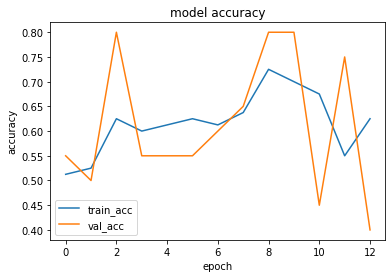

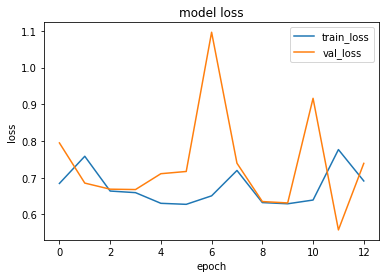

1it [00:00, 14563.56it/s]


prediction for video armflapping_1.mov is [[0.6432917]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.69159174]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.68397284]]


1it [00:00, 12865.96it/s]


prediction for video control_1.mov is [[0.6192357]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.61107796]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.60714376]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.7021 - accuracy: 0.4250 - precision: 0.4318 - recall: 0.4750 - val_loss: 0.6866 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6732 - accuracy: 0.5625 - precision: 0.5362 - recall: 0.9250 - val_loss: 0.6721 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6434 - accuracy: 0.5750 - precision: 0.5484 - recall: 0.8500 - val_loss: 0.6530 - val_accuracy: 0.8500 - val_precision: 0.8182 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6307 - accuracy: 0.6500 - precision: 0.6111 - recall: 0.8250 - val_loss: 0.7835 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 5/75


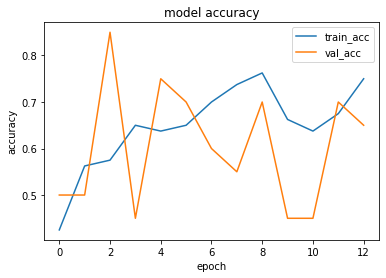

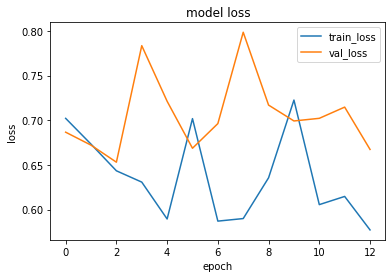

1it [00:00, 13189.64it/s]


prediction for video armflapping_1.mov is [[0.5120698]]


1it [00:00, 13400.33it/s]


prediction for video armflapping_3.mov is [[0.5244903]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.52157223]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.50184095]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.49790058]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.4979358]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6847 - accuracy: 0.5125 - precision: 0.5085 - recall: 0.7500 - val_loss: 0.6483 - val_accuracy: 0.5500 - val_precision: 0.5714 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6620 - accuracy: 0.7000 - precision: 0.7105 - recall: 0.6750 - val_loss: 0.6250 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6243 - accuracy: 0.6750 - precision: 0.7692 - recall: 0.5000 - val_loss: 0.6622 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6368 - accuracy: 0.6375 - precision: 0.6122 - recall: 0.7500 - val_loss: 0.6534 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 5/75
3

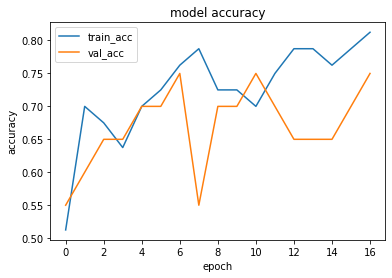

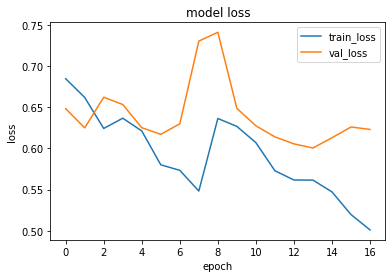

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.572157]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_3.mov is [[0.6213794]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.67741]]


1it [00:00, 14665.40it/s]


prediction for video control_1.mov is [[0.27385774]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.29078817]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.2603248]]


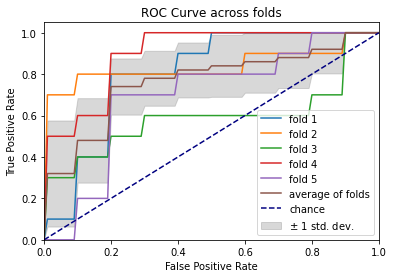

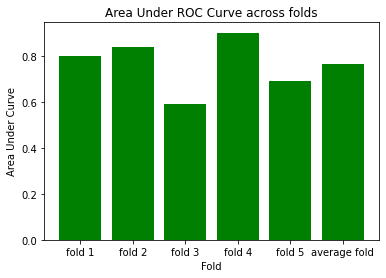

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6949 - accuracy: 0.4750 - precision: 0.4783 - recall: 0.5500 - val_loss: 0.7003 - val_accuracy: 0.5500 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6684 - accuracy: 0.4250 - precision: 0.3500 - recall: 0.1750 - val_loss: 0.6866 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6396 - accuracy: 0.5750 - precision: 0.5417 - recall: 0.9750 - val_loss: 0.6896 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6633 - accuracy: 0.5625 - precision: 0.5333 - recall: 1.0000 - val_loss: 0.6867 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 159ms/step 

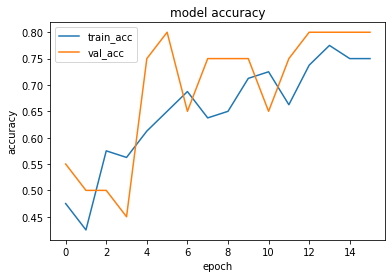

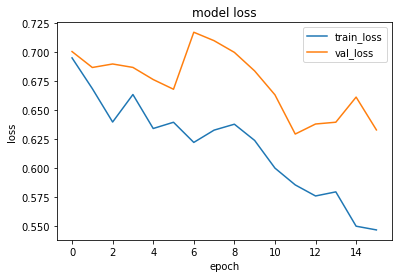

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.45489103]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.48941472]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.54610455]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.40349442]]


1it [00:00, 17260.51it/s]


prediction for video control_2.mov is [[0.38780022]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.392186]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6904 - accuracy: 0.6750 - precision: 0.7188 - recall: 0.5750 - val_loss: 0.6587 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6420 - accuracy: 0.6500 - precision: 0.6200 - recall: 0.7750 - val_loss: 0.6124 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6098 - accuracy: 0.6875 - precision: 0.6744 - recall: 0.7250 - val_loss: 0.5838 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6537 - accuracy: 0.7125 - precision: 0.6889 - recall: 0.7750 - val_loss: 0.5973 - val_accuracy: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000
Epoch 5/75
3/

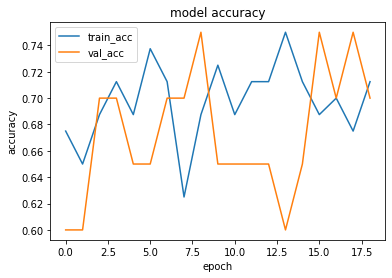

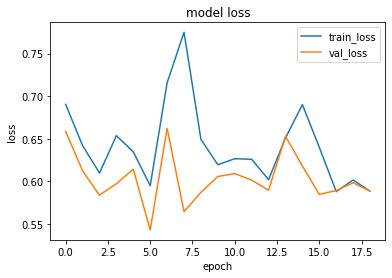

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.3673932]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.5746077]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.6218424]]


1it [00:00, 14873.42it/s]


prediction for video control_1.mov is [[0.31575635]]


1it [00:00, 16070.13it/s]


prediction for video control_2.mov is [[0.3059848]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.30585772]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6819 - accuracy: 0.5875 - precision: 0.5636 - recall: 0.7750 - val_loss: 0.7227 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6702 - accuracy: 0.5375 - precision: 0.5246 - recall: 0.8000 - val_loss: 0.5719 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6535 - accuracy: 0.6250 - precision: 0.5893 - recall: 0.8250 - val_loss: 0.6615 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6665 - accuracy: 0.5625 - precision: 0.5342 - recall: 0.9750 - val_loss: 0.6782 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 5/75


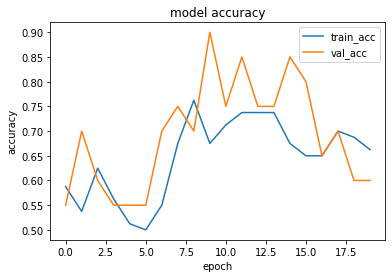

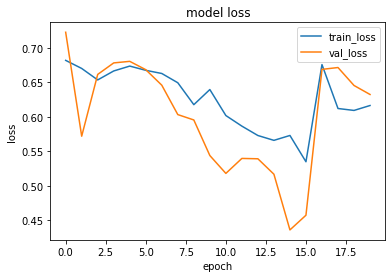

1it [00:00, 14122.24it/s]


prediction for video armflapping_1.mov is [[0.4551053]]


1it [00:00, 13842.59it/s]


prediction for video armflapping_3.mov is [[0.5223593]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.53214085]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.4152904]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.4033724]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.3940549]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 215ms/step - loss: 0.6899 - accuracy: 0.5250 - precision: 0.5156 - recall: 0.8250 - val_loss: 0.6394 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6518 - accuracy: 0.6375 - precision: 0.5932 - recall: 0.8750 - val_loss: 0.7187 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 183ms/step - loss: 0.6892 - accuracy: 0.5750 - precision: 0.5455 - recall: 0.9000 - val_loss: 0.6422 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 153ms/step - loss: 0.7107 - accuracy: 0.7000 - precision: 0.7857 - recall: 0.5500 - val_loss: 0.7404 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.4000
Epoch 5/75
3

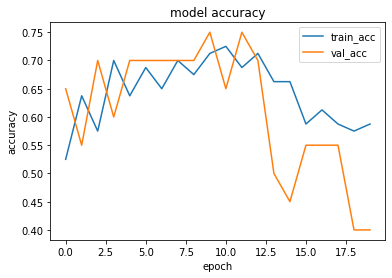

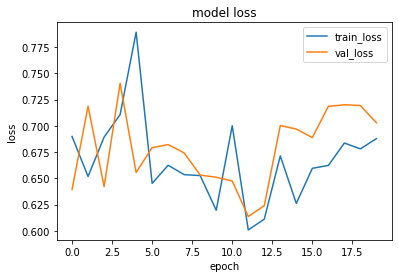

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.3949994]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.46367115]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.42193878]]


1it [00:00, 16070.13it/s]


prediction for video control_1.mov is [[0.38394192]]


1it [00:00, 14768.68it/s]


prediction for video control_2.mov is [[0.37691432]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.38335824]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 161ms/step - loss: 0.6858 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.6000 - val_loss: 0.6872 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6711 - accuracy: 0.5875 - precision: 0.5507 - recall: 0.9500 - val_loss: 0.9030 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6732 - accuracy: 0.5625 - precision: 0.5455 - recall: 0.7500 - val_loss: 0.6743 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6558 - accuracy: 0.5500 - precision: 0.5263 - recall: 1.0000 - val_loss: 0.6707 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/75


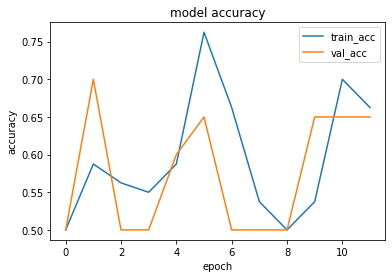

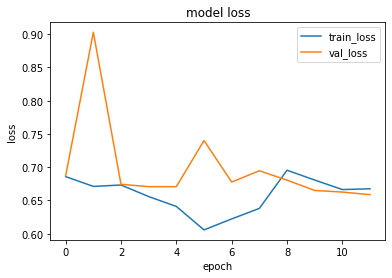

1it [00:00, 14768.68it/s]


prediction for video armflapping_1.mov is [[0.4808035]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.46231908]]


1it [00:00, 12787.51it/s]


prediction for video armflapping_2.mov is [[0.47222126]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.4667157]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.4534253]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.4559467]]


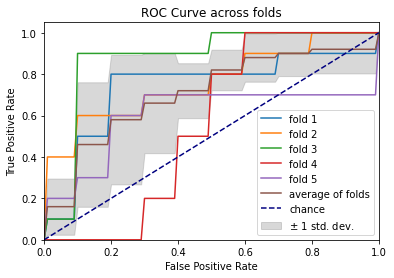

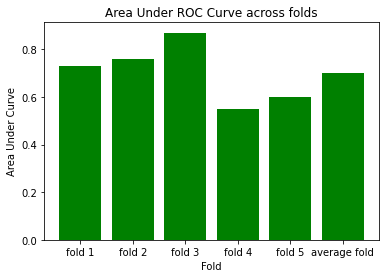

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6853 - accuracy: 0.6375 - precision: 0.6667 - recall: 0.5500 - val_loss: 0.6598 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6830 - accuracy: 0.4875 - precision: 0.4857 - recall: 0.4250 - val_loss: 0.6653 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6366 - accuracy: 0.6250 - precision: 0.5962 - recall: 0.7750 - val_loss: 0.6572 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6794 - accuracy: 0.5875 - precision: 0.5538 - recall: 0.9000 - val_loss: 0.6278 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 149ms/step 

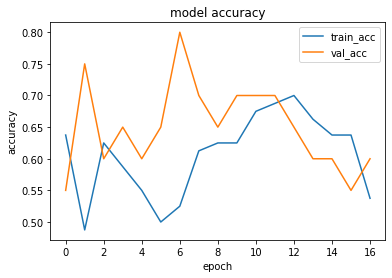

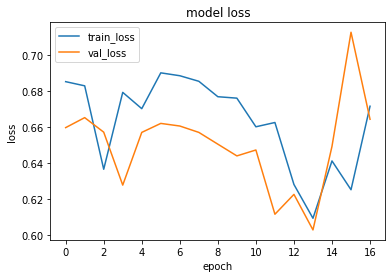

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.5060312]]


1it [00:00, 12052.60it/s]


prediction for video armflapping_3.mov is [[0.5129647]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_2.mov is [[0.50740993]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.4933292]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.48474428]]


1it [00:00, 2898.62it/s]


prediction for video control_3.mov is [[0.4859725]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6830 - accuracy: 0.5750 - precision: 0.5556 - recall: 0.7500 - val_loss: 0.6449 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 155ms/step - loss: 0.9251 - accuracy: 0.5875 - precision: 0.7333 - recall: 0.2750 - val_loss: 0.6590 - val_accuracy: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6591 - accuracy: 0.7125 - precision: 0.7297 - recall: 0.6750 - val_loss: 0.6895 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6601 - accuracy: 0.6750 - precision: 0.6458 - recall: 0.7750 - val_loss: 0.6706 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75
3

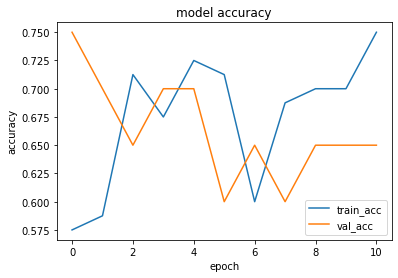

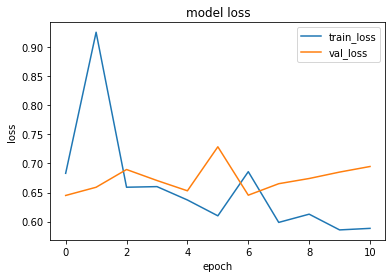

1it [00:00, 13315.25it/s]


prediction for video armflapping_1.mov is [[0.59061325]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_3.mov is [[0.6450587]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.65954787]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.3469124]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.3046233]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.39311403]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6924 - accuracy: 0.5875 - precision: 0.5778 - recall: 0.6500 - val_loss: 0.6950 - val_accuracy: 0.5500 - val_precision: 0.5455 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6526 - accuracy: 0.6875 - precision: 0.8947 - recall: 0.4250 - val_loss: 0.7311 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.5989 - accuracy: 0.5750 - precision: 0.5429 - recall: 0.9500 - val_loss: 1.0222 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6678 - accuracy: 0.6875 - precision: 0.6415 - recall: 0.8500 - val_loss: 0.7444 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 5/75


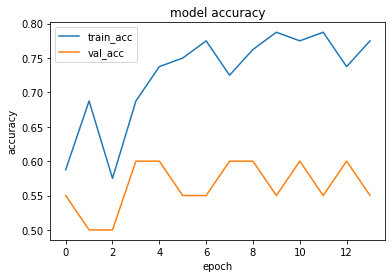

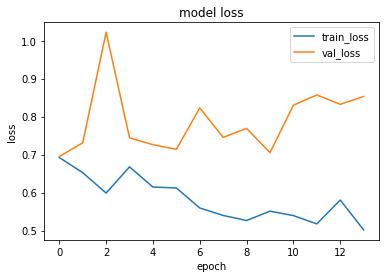

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.2726847]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.39300144]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.43015394]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.24983075]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.24286297]]


1it [00:00, 17260.51it/s]


prediction for video control_3.mov is [[0.2432707]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 144ms/step - loss: 0.7017 - accuracy: 0.4500 - precision: 0.4565 - recall: 0.5250 - val_loss: 0.6683 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6709 - accuracy: 0.5750 - precision: 0.5600 - recall: 0.7000 - val_loss: 0.8005 - val_accuracy: 0.5500 - val_precision: 0.5455 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7700 - accuracy: 0.5250 - precision: 0.5179 - recall: 0.7250 - val_loss: 0.6632 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6920 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.9500 - val_loss: 0.6631 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 5/75
3

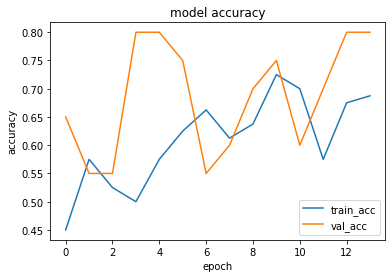

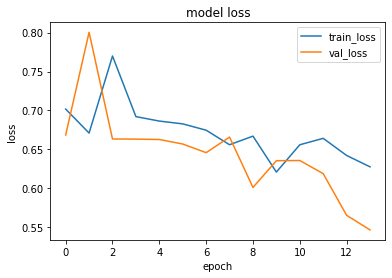

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.33939946]]


1it [00:00, 14027.77it/s]


prediction for video armflapping_3.mov is [[0.35678467]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_2.mov is [[0.3951607]]


1it [00:00, 16710.37it/s]


prediction for video control_1.mov is [[0.31547612]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.3044693]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.30289936]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 164ms/step - loss: 0.7053 - accuracy: 0.4875 - precision: 0.4615 - recall: 0.1500 - val_loss: 0.6975 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6799 - accuracy: 0.6125 - precision: 0.5692 - recall: 0.9250 - val_loss: 0.6815 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6668 - accuracy: 0.6750 - precision: 0.6591 - recall: 0.7250 - val_loss: 0.6468 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6317 - accuracy: 0.6500 - precision: 0.6500 - recall: 0.6500 - val_loss: 0.6157 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 5/75


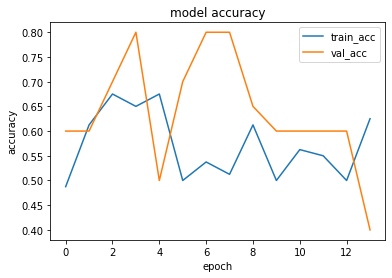

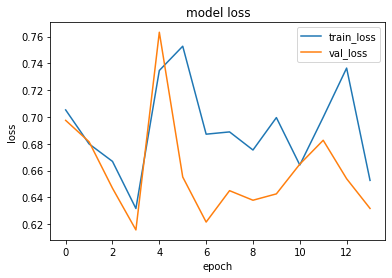

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.52201384]]


1it [00:00, 13189.64it/s]


prediction for video armflapping_3.mov is [[0.5258078]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.50750095]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.5444732]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.5351064]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.5403364]]


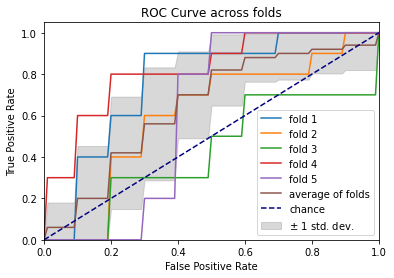

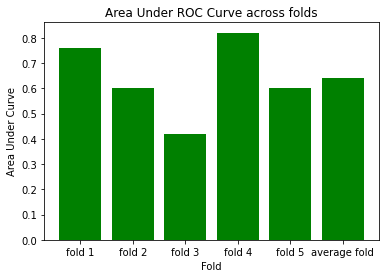

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6798 - accuracy: 0.5625 - precision: 0.5373 - recall: 0.9000 - val_loss: 0.6770 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6717 - accuracy: 0.5375 - precision: 0.6000 - recall: 0.2250 - val_loss: 0.6535 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 151ms/step - loss: 0.6540 - accuracy: 0.6000 - precision: 0.5800 - recall: 0.7250 - val_loss: 0.6561 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6940 - accuracy: 0.7500 - precision: 0.7632 - recall: 0.7250 - val_loss: 0.6222 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 153

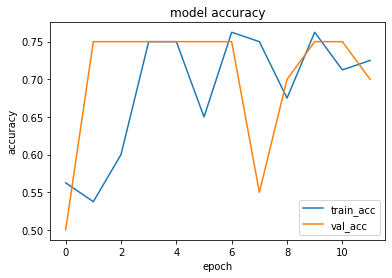

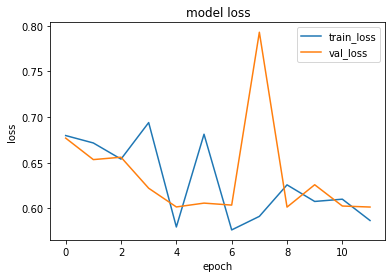

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.54566145]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.6097529]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.5838526]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.5114463]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.49485782]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.4913418]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6974 - accuracy: 0.4875 - precision: 0.4894 - recall: 0.5750 - val_loss: 0.6668 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6828 - accuracy: 0.5750 - precision: 0.8750 - recall: 0.1750 - val_loss: 0.6195 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6900 - accuracy: 0.6000 - precision: 0.5606 - recall: 0.9250 - val_loss: 0.5953 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6866 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.6533 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 5/75
3

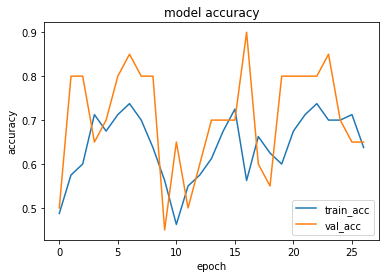

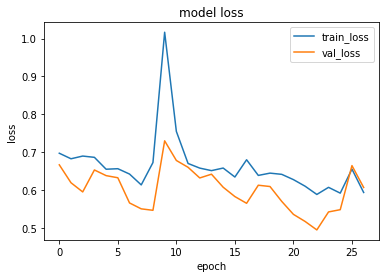

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.625549]]


1it [00:00, 12336.19it/s]


prediction for video armflapping_3.mov is [[0.68502074]]


1it [00:00, 11096.04it/s]


prediction for video armflapping_2.mov is [[0.6481465]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.6057036]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.6010231]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.5953343]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 164ms/step - loss: 0.6873 - accuracy: 0.5875 - precision: 0.5593 - recall: 0.8250 - val_loss: 0.6698 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6479 - accuracy: 0.6750 - precision: 0.7059 - recall: 0.6000 - val_loss: 0.8219 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6537 - accuracy: 0.6500 - precision: 0.6364 - recall: 0.7000 - val_loss: 0.6325 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6181 - accuracy: 0.6875 - precision: 0.8947 - recall: 0.4250 - val_loss: 0.6617 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 5/75
3

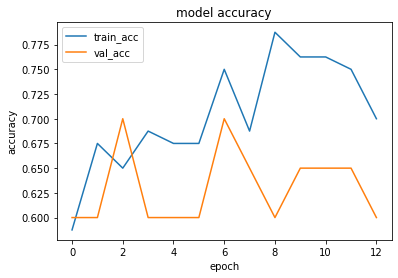

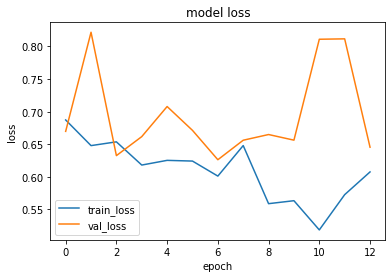

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.2518684]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_3.mov is [[0.7848197]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.25628436]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.24862066]]


1it [00:00, 12985.46it/s]


prediction for video control_2.mov is [[0.24724281]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.24706975]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6913 - accuracy: 0.5625 - precision: 0.6000 - recall: 0.3750 - val_loss: 0.7376 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6700 - accuracy: 0.5375 - precision: 0.5200 - recall: 0.9750 - val_loss: 0.6866 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2000
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6652 - accuracy: 0.5250 - precision: 0.5625 - recall: 0.2250 - val_loss: 0.6725 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6110 - accuracy: 0.7000 - precision: 0.6818 - recall: 0.7500 - val_loss: 0.6188 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 5/75


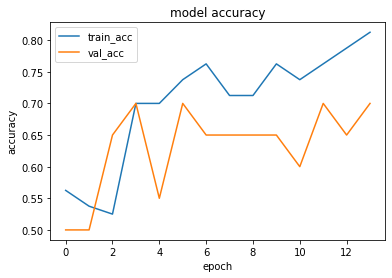

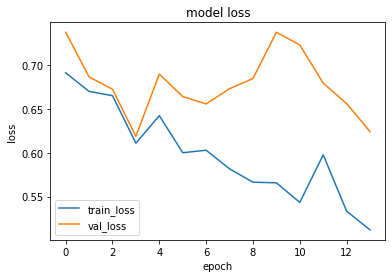

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.1915482]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.51103336]]


1it [00:00, 10305.42it/s]


prediction for video armflapping_2.mov is [[0.61616576]]


1it [00:00, 13842.59it/s]


prediction for video control_1.mov is [[0.1449211]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.1335873]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.13061747]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6964 - accuracy: 0.5375 - precision: 0.5517 - recall: 0.4000 - val_loss: 0.6712 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6804 - accuracy: 0.5375 - precision: 0.6364 - recall: 0.1750 - val_loss: 0.6596 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6654 - accuracy: 0.6500 - precision: 0.6111 - recall: 0.8250 - val_loss: 0.6116 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6229 - accuracy: 0.6375 - precision: 0.5846 - recall: 0.9500 - val_loss: 0.6107 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 5/75


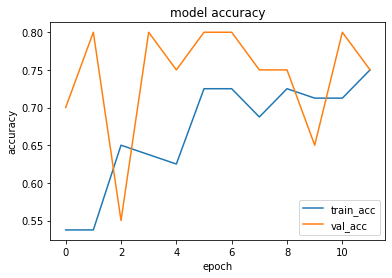

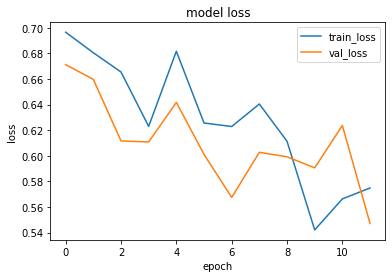

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.58234996]]


1it [00:00, 14563.56it/s]


prediction for video armflapping_3.mov is [[0.59310156]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_2.mov is [[0.62902296]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.11160713]]


1it [00:00, 12520.31it/s]


prediction for video control_2.mov is [[0.10399106]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.32419175]]


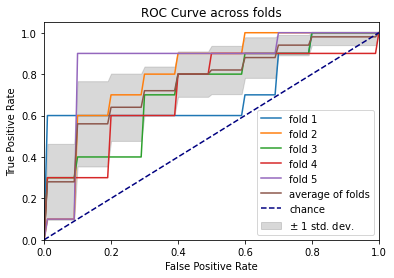

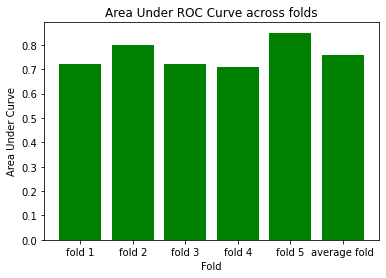

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 164ms/step - loss: 0.6872 - accuracy: 0.5250 - precision: 0.5333 - recall: 0.4000 - val_loss: 0.6949 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6477 - accuracy: 0.6625 - precision: 0.6275 - recall: 0.8000 - val_loss: 0.6708 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6362 - accuracy: 0.6000 - precision: 0.5625 - recall: 0.9000 - val_loss: 0.6343 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6116 - accuracy: 0.6875 - precision: 0.7586 - recall: 0.5500 - val_loss: 0.7251 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 149ms/step 

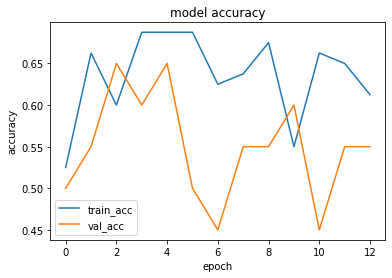

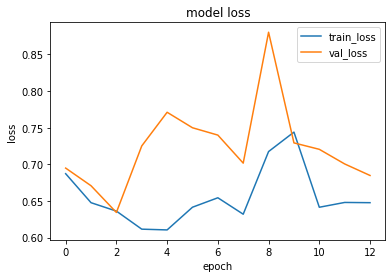

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.40344965]]


1it [00:00, 10305.42it/s]


prediction for video armflapping_3.mov is [[0.42688924]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.47175413]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.36780208]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.35608223]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.35103047]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 160ms/step - loss: 0.7065 - accuracy: 0.4000 - precision: 0.4310 - recall: 0.6250 - val_loss: 0.6978 - val_accuracy: 0.5500 - val_precision: 0.5385 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6778 - accuracy: 0.6625 - precision: 0.7241 - recall: 0.5250 - val_loss: 0.6644 - val_accuracy: 0.5500 - val_precision: 0.6000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6599 - accuracy: 0.7125 - precision: 0.7073 - recall: 0.7250 - val_loss: 0.6763 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6377 - accuracy: 0.7250 - precision: 0.8750 - recall: 0.5250 - val_loss: 0.6396 - val_accuracy: 0.5500 - val_precision: 0.6000 - val_recall: 0.3000
Epoch 5/75


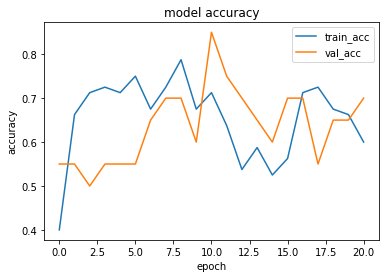

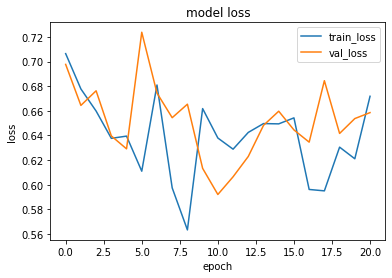

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.54279524]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.55168194]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.5488846]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.5152488]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.49236804]]


1it [00:00, 13842.59it/s]


prediction for video control_3.mov is [[0.50046617]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6990 - accuracy: 0.4125 - precision: 0.4314 - recall: 0.5500 - val_loss: 0.6522 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6885 - accuracy: 0.6375 - precision: 0.5846 - recall: 0.9500 - val_loss: 0.6514 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6615 - accuracy: 0.5625 - precision: 0.6667 - recall: 0.2500 - val_loss: 0.6634 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6489 - accuracy: 0.7250 - precision: 0.7143 - recall: 0.7500 - val_loss: 0.6418 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 5/75


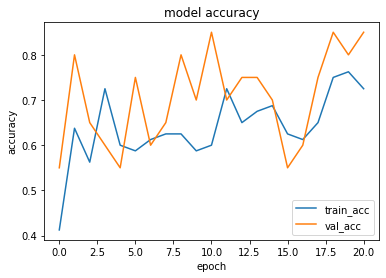

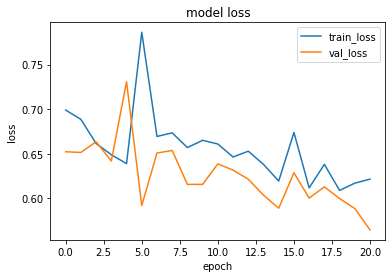

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.4781103]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5083914]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.53523517]]


1it [00:00, 12671.61it/s]


prediction for video control_1.mov is [[0.43838254]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.42456824]]


1it [00:00, 14563.56it/s]


prediction for video control_3.mov is [[0.41450056]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6931 - accuracy: 0.3875 - precision: 0.4000 - recall: 0.4500 - val_loss: 0.6736 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6605 - accuracy: 0.6000 - precision: 0.5690 - recall: 0.8250 - val_loss: 0.8911 - val_accuracy: 0.5500 - val_precision: 0.5455 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 160ms/step - loss: 1.1596 - accuracy: 0.5125 - precision: 0.5385 - recall: 0.1750 - val_loss: 0.7654 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.7373 - accuracy: 0.5375 - precision: 0.5652 - recall: 0.3250 - val_loss: 0.7462 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epo

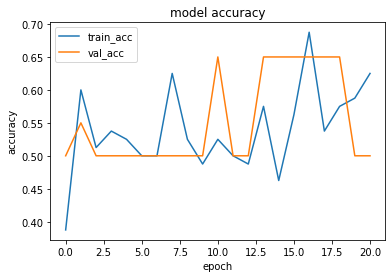

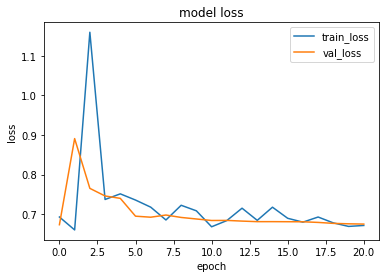

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.51270205]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.47501633]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.51107955]]


1it [00:00, 14217.98it/s]


prediction for video control_1.mov is [[0.51248485]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.5124333]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.51242954]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6789 - accuracy: 0.5250 - precision: 0.5294 - recall: 0.4500 - val_loss: 0.6919 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6434 - accuracy: 0.5500 - precision: 0.5270 - recall: 0.9750 - val_loss: 0.9095 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.8319 - accuracy: 0.5875 - precision: 0.6207 - recall: 0.4500 - val_loss: 0.6655 - val_accuracy: 0.4500 - val_precision: 0.4667 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 167ms/step - loss: 0.6622 - accuracy: 0.6000 - precision: 0.5667 - recall: 0.8500 - val_loss: 0.6568 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 5/75


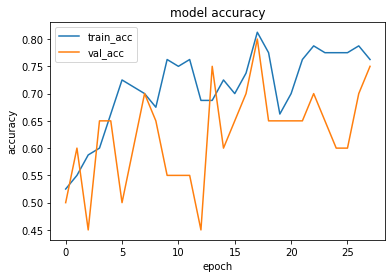

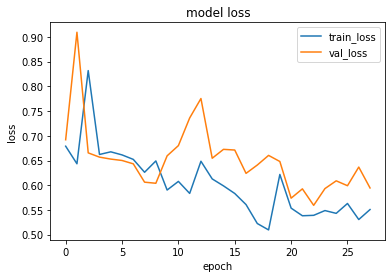

1it [00:00, 6326.25it/s]


prediction for video armflapping_1.mov is [[0.5721508]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.68756294]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.67516536]]


1it [00:00, 15196.75it/s]


prediction for video control_1.mov is [[0.49527103]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.4653008]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.44277048]]


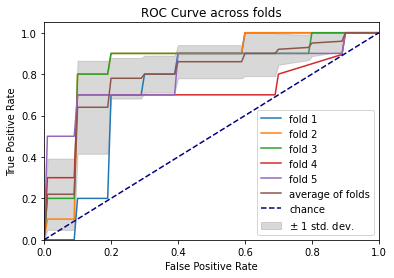

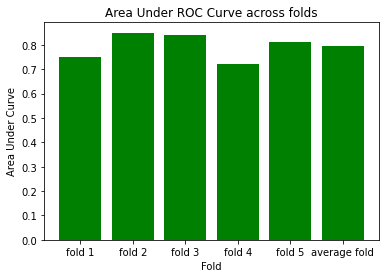

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 162ms/step - loss: 0.7200 - accuracy: 0.4375 - precision: 0.3529 - recall: 0.1500 - val_loss: 0.6854 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6986 - accuracy: 0.5125 - precision: 0.5065 - recall: 0.9750 - val_loss: 0.6738 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6755 - accuracy: 0.5750 - precision: 0.5577 - recall: 0.7250 - val_loss: 0.6859 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6284 - accuracy: 0.6750 - precision: 0.6346 - recall: 0.8250 - val_loss: 0.7377 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 150ms/step 

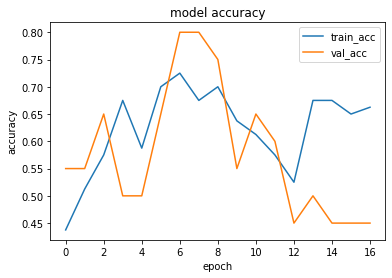

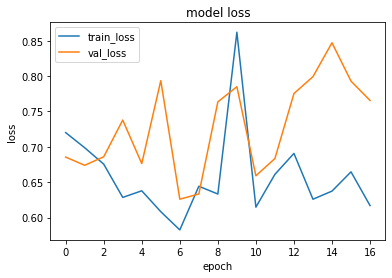

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.52728224]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.54573745]]


1it [00:00, 14027.77it/s]


prediction for video armflapping_2.mov is [[0.5615135]]


1it [00:00, 9532.51it/s]


prediction for video control_1.mov is [[0.50649554]]


1it [00:00, 11491.24it/s]


prediction for video control_2.mov is [[0.4940242]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.49306285]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6887 - accuracy: 0.5625 - precision: 0.6000 - recall: 0.3750 - val_loss: 0.7447 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6207 - accuracy: 0.7250 - precision: 0.6800 - recall: 0.8500 - val_loss: 0.6416 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.5774 - accuracy: 0.7500 - precision: 0.7083 - recall: 0.8500 - val_loss: 1.1069 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.9228 - accuracy: 0.5250 - precision: 0.5139 - recall: 0.9250 - val_loss: 0.7623 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 5/75


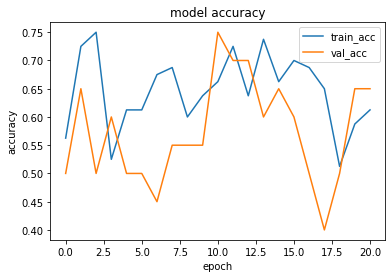

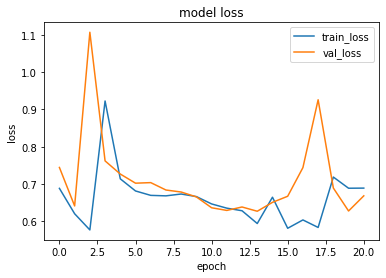

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.425556]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.5264195]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.47409633]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.4146443]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.38253838]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.43082833]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6980 - accuracy: 0.5375 - precision: 0.5429 - recall: 0.4750 - val_loss: 0.6737 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6555 - accuracy: 0.7125 - precision: 0.6491 - recall: 0.9250 - val_loss: 0.7230 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.7657 - accuracy: 0.6500 - precision: 0.6429 - recall: 0.6750 - val_loss: 0.8717 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.7573 - accuracy: 0.5625 - precision: 0.5333 - recall: 1.0000 - val_loss: 0.6750 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 5/75


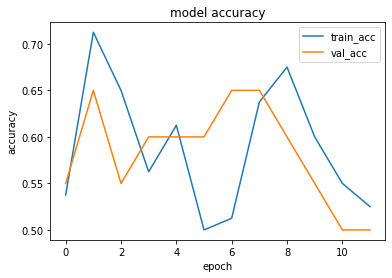

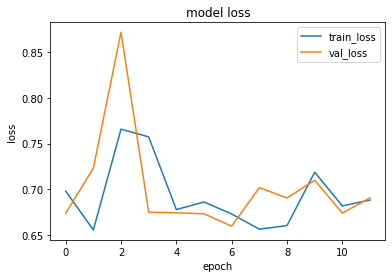

ZeroDivisionError: float division by zero

In [44]:
for seed in SEEDS:
    """ the only problem with this is that it's a basically 100 seed loop, which will take around 500 minutes of running"""
    np.random.seed(seed) # set seed 
    
    # first sort all of the folds 
    N = np.random.permutation(ARMFLAPPING_FRAMES.shape[0])
    ARMFLAPPING_FRAMES = ARMFLAPPING_FRAMES[N]
    CONTROL_FRAMES = CONTROL_FRAMES[N]

    # split them into 5 folds 
    ARMFLAPPING_FRAMES_SPLIT = np.array_split(ARMFLAPPING_FRAMES, 5)
    CONTROL_FRAMES_SPLIT = np.array_split(CONTROL_FRAMES, 5)

    # then run them 5x 
    checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
    cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

In [45]:
with open("one_landmark_hundred_seeds_results", 'wb') as f: 
    pickle.dump((META_RESULT_MATRIX, AVERAGE_AUROCS, AVERAGE_TPRS), f)

In [47]:
import pickle, numpy as np
with open("one_landmark_hundred_seeds_results", 'rb') as f: 
 (META_RESULT_MATRIX, AVERAGE_AUROCS, AVERAGE_TPRS) = pickle.load(f)

In [48]:
META_RESULT_MATRIX = np.array(META_RESULT_MATRIX)
np.mean(META_RESULT_MATRIX, axis=0) # yoo the results for one hundred landmarks do be completely ass 

array([0.69155405, 0.70664611, 0.69121622, 0.68110828, 0.63513513,
       0.63908198, 0.62972973, 0.61179131])

In [49]:
for i in range(8): 
    print(np.mean(META_RESULT_MATRIX[:, i], axis=0), np.std(META_RESULT_MATRIX[:, i], axis=0))

0.6915540534096796 0.07857761828273378
0.7066461121713793 0.08523621538945772
0.6912162150885608 0.1801103443352474
0.6811082822124161 0.11083689035845078
0.6351351327187306 0.11322356653811351
0.6390819847583771 0.1358555647385105
0.6297297314614863 0.24369327153381146
0.6117913147331504 0.17048888832358136


In [52]:
METRICS = []
for fold_results in np.array_split(META_RESULT_MATRIX, 100):
    METRICS.append(np.mean(fold_results, axis = 0)) 

METRICS = np.around(np.array(METRICS), 10)
print(METRICS)

print(f"training accuracy : {np.mean(METRICS[:, 0])} +/- {np.std(METRICS[:, 0])}")
print(f"training precision : {np.mean(METRICS[:, 1])} +/- {np.std(METRICS[:, 1])}")
print(f"training recall : {np.mean(METRICS[:, 2])} +/- {np.std(METRICS[:, 2])}")
print(f"training f1 : {np.mean(METRICS[:, 3])} +/- {np.std(METRICS[:, 3])}")
print(f"validation accuracy : {np.mean(METRICS[:, 4])} +/- {np.std(METRICS[:, 4])}")
print(f"validation precision : {np.mean(METRICS[:, 5])} +/- {np.std(METRICS[:, 5])}")
print(f"validation recall : {np.mean(METRICS[:, 6])} +/- {np.std(METRICS[:, 6])}")
print(f"validation f1 : {np.mean(METRICS[:, 7])} +/- {np.std(METRICS[:, 7])}")

[[0.61250001 0.5633803  1.         0.72072074 0.69999999 0.625
  1.         0.76923077]
 [0.75       0.72727275 0.80000001 0.76190478 0.5        0.5
  0.30000001 0.37500001]
 [0.77499998 0.75       0.82499999 0.78571428 0.64999998 0.66666669
  0.60000002 0.63157897]
 [0.77499998 0.75       0.82499999 0.78571428 0.55000001 0.5714286
  0.40000001 0.47058825]
 [0.55000001 0.6111111  0.27500001 0.37931035 0.55000001 0.66666669
  0.2        0.30769231]
 [0.75       0.79411763 0.67500001 0.72972973 0.64999998 0.71428573
  0.5        0.5882353 ]
 [0.57499999 0.54285717 0.94999999 0.69090911 0.64999998 0.60000002
  0.89999998 0.72000001]
 [0.57499999 0.5714286  0.60000002 0.58536588 0.60000002 0.55555558
  1.         0.71428574]
 [0.77499998 0.77499998 0.77499998 0.77499998 0.80000001 0.875
  0.69999999 0.77777777]
 [0.77499998 0.78947371 0.75       0.76923078 0.75       0.77777779
  0.69999999 0.7368421 ]
 [0.75       0.79411763 0.67500001 0.72972973 0.64999998 0.63636363
  0.69999999 0.66666

In [14]:
# create plots of evreything 

training_acc = np.mean(META_RESULT_MATRIX[:, 0], axis=0)

labels = ['Accuracy', "Precision", "Recall", "F1"]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(7, 6)
rects1 = ax.bar(x - width/2, [training_acc, training_precision, training_recall, training_f1], width, label='Training', color = "tab:blue")
rects2 = ax.bar(x + width/2, [validation_acc, validation_precision, validation_recall, validation_f1], width, label='Validation', color="tab:green")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric')
if FOLD_NUMBER != 5: 
    ax.set_title(f"Training vs. Testing Metrics: Fold {FOLD_NUMBER + 1} (No Aug)")
else: 
    ax.set_title("Training vs. Testing Metrics All Folds (No Aug)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper right")

array([[0.80000001, 0.80000001, 0.80000001, 0.80000001, 0.60000002,
        0.60000002, 0.60000002, 0.60000002],
       [0.77499998, 0.76190478, 0.80000001, 0.78048782, 0.64999998,
        0.66666669, 0.60000002, 0.63157897],
       [0.75      , 0.72727275, 0.80000001, 0.76190478, 0.69999999,
        0.69999999, 0.69999999, 0.69999999],
       [0.85000002, 0.8888889 , 0.80000001, 0.84210527, 0.69999999,
        0.69999999, 0.69999999, 0.69999999],
       [0.72500002, 0.72500002, 0.72500002, 0.72500002, 0.85000002,
        0.81818181, 0.89999998, 0.85714284]])

0.7636873058008137


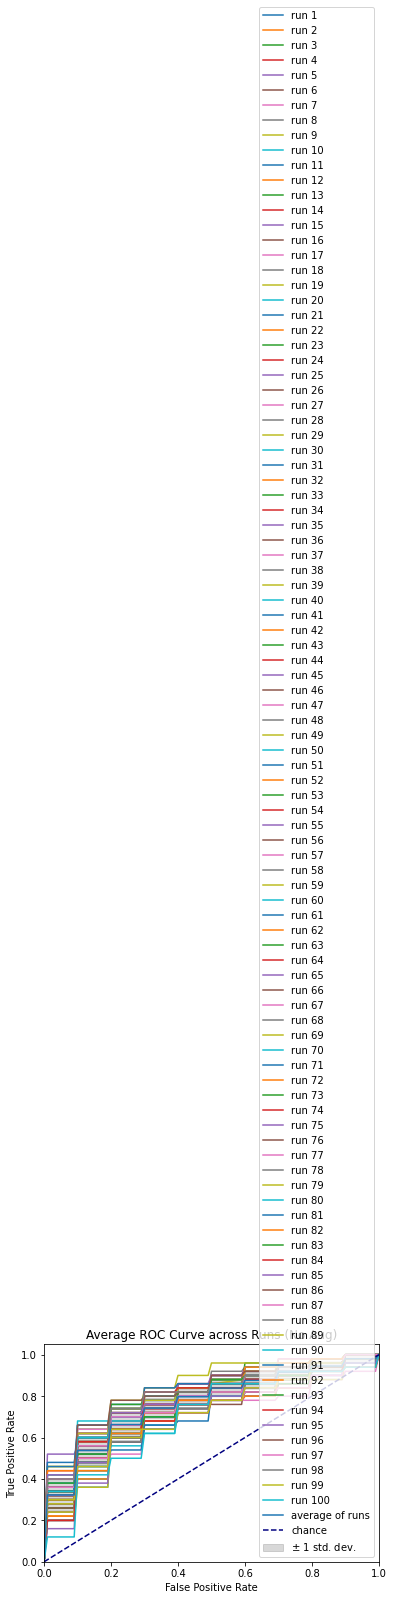

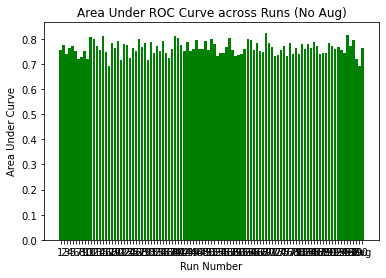

In [39]:
# REEE RUN THIS STUFF 
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101)) # save the images here 

In [40]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

(0.76189, 0.026550118867552906)

In [41]:
def interpret(metrics_string):
     metrics = []
     for i in range(len(metrics_string)):
         try:
             index = metrics_string.index(":")
             metrics.append(metrics_string[index + 2 : index + 8])
             metrics_string = metrics_string[index + 9:]
         except Exception as e:
             return [float(m) for m in metrics][1:]

In [42]:
METRICS = [] # training acc, training pres, training recall, validation acc, validation pres, validation recall 

# for all of the 50 runs have a (50, 6 + 2) matrix, and then use that to store data and compute scores 
import numpy as np
meta_results = []
meta_results.append("3/3 [==============================] - 0s 143ms/step - loss: 0.5490 - accuracy: 0.7625 - precision_127: 0.7692 - recall_127: 0.7500 - val_loss: 0.6196 - val_accuracy: 0.7000 - val_precision_127: 0.6429 - val_recall_127: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5468 - accuracy: 0.7500 - precision_128: 0.7381 - recall_128: 0.7750 - val_loss: 0.4929 - val_accuracy: 0.7500 - val_precision_128: 0.7778 - val_recall_128: 0.7000")
meta_results.append("3/3 [==============================] - 0s 148ms/step - loss: 0.5195 - accuracy: 0.7875 - precision_129: 0.8485 - recall_129: 0.7000 - val_loss: 0.6768 - val_accuracy: 0.6500 - val_precision_129: 0.7143 - val_recall_129: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5528 - accuracy: 0.7375 - precision_130: 0.8800 - recall_130: 0.5500 - val_loss: 0.6188 - val_accuracy: 0.7000 - val_precision_130: 0.7500 - val_recall_130: 0.6000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5276 - accuracy: 0.7500 - precision_131: 0.7500 - recall_131: 0.7500 - val_loss: 0.5546 - val_accuracy: 0.7500 - val_precision_131: 0.7778 - val_recall_131: 0.7000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.3641 - accuracy: 0.8250 - precision_133: 0.9333 - recall_133: 0.7000 - val_loss: 0.8364 - val_accuracy: 0.7000 - val_precision_133: 0.6429 - val_recall_133: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5302 - accuracy: 0.7750 - precision_134: 0.7750 - recall_134: 0.7750 - val_loss: 0.5209 - val_accuracy: 0.8000 - val_precision_134: 0.8000 - val_recall_134: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5198 - accuracy: 0.7375 - precision_135: 0.7209 - recall_135: 0.7750 - val_loss: 0.6696 - val_accuracy: 0.5500 - val_precision_135: 0.5714 - val_recall_135: 0.4000")
meta_results.append('3/3 [==============================] - 0s 142ms/step - loss: 0.5037 - accuracy: 0.7875 - precision_136: 0.8108 - recall_136: 0.7500 - val_loss: 0.5018 - val_accuracy: 0.7500 - val_precision_136: 0.7273 - val_recall_136: 0.8000')
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.6638 - accuracy: 0.6000 - precision_137: 0.6053 - recall_137: 0.5750 - val_loss: 0.6271 - val_accuracy: 0.6000 - val_precision_137: 0.6250 - val_recall_137: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4704 - accuracy: 0.7875 - precision_139: 0.8485 - recall_139: 0.7000 - val_loss: 0.6656 - val_accuracy: 0.7000 - val_precision_139: 0.6667 - val_recall_139: 0.8000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.6160 - accuracy: 0.6500 - precision_140: 0.6875 - recall_140: 0.5500 - val_loss: 0.5326 - val_accuracy: 0.8500 - val_precision_140: 0.8182 - val_recall_140: 0.9000")
meta_results.append("3/3 [==============================] - 0s 134ms/step - loss: 0.4795 - accuracy: 0.7625 - precision_141: 0.7838 - recall_141: 0.7250 - val_loss: 0.7107 - val_accuracy: 0.6500 - val_precision_141: 0.8000 - val_recall_141: 0.4000")
meta_results.append("3/3 [==============================] - 0s 121ms/step - loss: 0.5433 - accuracy: 0.7375 - precision_142: 0.9130 - recall_142: 0.5250 - val_loss: 0.5958 - val_accuracy: 0.7000 - val_precision_142: 0.7000 - val_recall_142: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.4387 - accuracy: 0.8375 - precision_143: 0.9091 - recall_143: 0.7500 - val_loss: 0.8756 - val_accuracy: 0.7000 - val_precision_143: 0.6429 - val_recall_143: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5071 - accuracy: 0.7750 - precision_145: 0.8235 - recall_145: 0.7000 - val_loss: 0.6108 - val_accuracy: 0.7000 - val_precision_145: 0.6429 - val_recall_145: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4103 - accuracy: 0.7875 - precision_146: 0.7674 - recall_146: 0.8250 - val_loss: 0.6352 - val_accuracy: 0.7500 - val_precision_146: 0.7273 - val_recall_146: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5201 - accuracy: 0.7375 - precision_147: 0.8065 - recall_147: 0.6250 - val_loss: 0.7552 - val_accuracy: 0.5500 - val_precision_147: 0.6000 - val_recall_147: 0.3000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4809 - accuracy: 0.7750 - precision_148: 0.7750 - recall_148: 0.7750 - val_loss: 0.5301 - val_accuracy: 0.7500 - val_precision_148: 0.7273 - val_recall_148: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.6238 - accuracy: 0.7250 - precision_149: 0.6957 - recall_149: 0.8000 - val_loss: 0.5609 - val_accuracy: 0.7000 - val_precision_149: 0.7500 - val_recall_149: 0.6000")
meta_results.append("3/3 [==============================] - 0s 147ms/step - loss: 0.4444 - accuracy: 0.8125 - precision_151: 0.8571 - recall_151: 0.7500 - val_loss: 0.6537 - val_accuracy: 0.7000 - val_precision_151: 0.6667 - val_recall_151: 0.8000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4550 - accuracy: 0.8000 - precision_152: 0.7500 - recall_152: 0.9000 - val_loss: 0.6105 - val_accuracy: 0.7500 - val_precision_152: 0.7778 - val_recall_152: 0.7000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.4810 - accuracy: 0.7625 - precision_153: 0.8000 - recall_153: 0.7000 - val_loss: 0.6956 - val_accuracy: 0.6500 - val_precision_153: 0.7143 - val_recall_153: 0.5000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.4951 - accuracy: 0.7625 - precision_154: 0.7692 - recall_154: 0.7500 - val_loss: 0.5621 - val_accuracy: 0.7500 - val_precision_154: 0.7273 - val_recall_154: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_155: 0.8421 - recall_155: 0.8000 - val_loss: 0.5144 - val_accuracy: 0.7500 - val_precision_155: 0.7778 - val_recall_155: 0.7000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.5146 - accuracy: 0.7375 - precision_157: 0.7568 - recall_157: 0.7000 - val_loss: 0.6470 - val_accuracy: 0.7000 - val_precision_157: 0.6429 - val_recall_157: 0.9000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5297 - accuracy: 0.7750 - precision_158: 0.7895 - recall_158: 0.7500 - val_loss: 0.5801 - val_accuracy: 0.7500 - val_precision_158: 0.7778 - val_recall_158: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4522 - accuracy: 0.7750 - precision_159: 0.8056 - recall_159: 0.7250 - val_loss: 0.6115 - val_accuracy: 0.6000 - val_precision_159: 0.7500 - val_recall_159: 0.3000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.5559 - accuracy: 0.7250 - precision_160: 0.6957 - recall_160: 0.8000 - val_loss: 0.5596 - val_accuracy: 0.7000 - val_precision_160: 0.6667 - val_recall_160: 0.8000")
meta_results.append("3/3 [==============================] - 0s 175ms/step - loss: 0.5519 - accuracy: 0.7750 - precision_161: 0.8438 - recall_161: 0.6750 - val_loss: 0.5466 - val_accuracy: 0.6500 - val_precision_161: 0.7143 - val_recall_161: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4980 - accuracy: 0.7750 - precision_163: 0.8235 - recall_163: 0.7000 - val_loss: 0.6757 - val_accuracy: 0.6500 - val_precision_163: 0.6154 - val_recall_163: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4898 - accuracy: 0.7750 - precision_164: 0.7895 - recall_164: 0.7500 - val_loss: 0.6056 - val_accuracy: 0.7000 - val_precision_164: 0.7000 - val_recall_164: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.5320 - accuracy: 0.7375 - precision_165: 0.7209 - recall_165: 0.7750 - val_loss: 0.7340 - val_accuracy: 0.6500 - val_precision_165: 0.6364 - val_recall_165: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4484 - accuracy: 0.7750 - precision_166: 0.7895 - recall_166: 0.7500 - val_loss: 0.5302 - val_accuracy: 0.7500 - val_precision_166: 0.7273 - val_recall_166: 0.8000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6792 - accuracy: 0.6750 - precision_167: 0.6522 - recall_167: 0.7500 - val_loss: 0.6917 - val_accuracy: 0.5500 - val_precision_167: 0.5556 - val_recall_167: 0.5000")
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.4365 - accuracy: 0.8125 - precision_169: 0.8788 - recall_169: 0.7250 - val_loss: 0.7150 - val_accuracy: 0.6500 - val_precision_169: 0.6364 - val_recall_169: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5207 - accuracy: 0.7750 - precision_170: 0.7750 - recall_170: 0.7750 - val_loss: 0.5656 - val_accuracy: 0.7500 - val_precision_170: 0.7778 - val_recall_170: 0.7000")
meta_results.append("3/3 [==============================] - 0s 131ms/step - loss: 0.4846 - accuracy: 0.7625 - precision_171: 0.7692 - recall_171: 0.7500 - val_loss: 0.7023 - val_accuracy: 0.6500 - val_precision_171: 0.6667 - val_recall_171: 0.6000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_172: 0.8824 - recall_172: 0.7500 - val_loss: 0.8445 - val_accuracy: 0.7000 - val_precision_172: 0.7500 - val_recall_172: 0.6000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.6846 - accuracy: 0.5750 - precision_173: 0.5682 - recall_173: 0.6250 - val_loss: 0.6460 - val_accuracy: 0.6000 - val_precision_173: 0.6250 - val_recall_173: 0.5000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4731 - accuracy: 0.7625 - precision_175: 0.7838 - recall_175: 0.7250 - val_loss: 0.6003 - val_accuracy: 0.7500 - val_precision_175: 0.6923 - val_recall_175: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.6343 - accuracy: 0.6875 - precision_176: 0.6744 - recall_176: 0.7250 - val_loss: 0.6167 - val_accuracy: 0.7000 - val_precision_176: 1.0000 - val_recall_176: 0.4000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6491 - accuracy: 0.5875 - precision_177: 0.6061 - recall_177: 0.5000 - val_loss: 0.6270 - val_accuracy: 0.6000 - val_precision_177: 1.0000 - val_recall_177: 0.2000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4416 - accuracy: 0.8000 - precision_178: 0.8333 - recall_178: 0.7500 - val_loss: 0.6544 - val_accuracy: 0.6500 - val_precision_178: 0.7143 - val_recall_178: 0.5000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4658 - accuracy: 0.8125 - precision_179: 0.9032 - recall_179: 0.7000 - val_loss: 0.6116 - val_accuracy: 0.7500 - val_precision_179: 0.7778 - val_recall_179: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4735 - accuracy: 0.8000 - precision_181: 0.8750 - recall_181: 0.7000 - val_loss: 0.6479 - val_accuracy: 0.6500 - val_precision_181: 0.6667 - val_recall_181: 0.6000")
meta_results.append("3/3 [==============================] - 0s 153ms/step - loss: 0.5056 - accuracy: 0.7750 - precision_182: 0.7895 - recall_182: 0.7500 - val_loss: 0.4801 - val_accuracy: 0.7500 - val_precision_182: 0.7778 - val_recall_182: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4631 - accuracy: 0.8000 - precision_183: 0.8000 - recall_183: 0.8000 - val_loss: 0.7841 - val_accuracy: 0.5000 - val_precision_183: 0.5000 - val_recall_183: 0.3000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4344 - accuracy: 0.8500 - precision_184: 0.8684 - recall_184: 0.8250 - val_loss: 0.6026 - val_accuracy: 0.7000 - val_precision_184: 0.6667 - val_recall_184: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.5167 - accuracy: 0.7375 - precision_185: 0.7111 - recall_185: 0.8000 - val_loss: 0.5716 - val_accuracy: 0.7000 - val_precision_185: 0.7500 - val_recall_185: 0.6000")

METRICS = [interpret(result) for result in meta_results]

In [43]:
METRICS = np.array(METRICS)

METRICS = np.delete(METRICS, obj=3, axis=1)
METRICS.shape

(50, 6)

In [44]:
train_acc = METRICS[:, 0]
train_pres = METRICS[:, 1]
train_recall = METRICS[:, 2]
val_acc = METRICS[:, 3]
val_pres = METRICS[:, 4]
val_recall = METRICS[:, 5]

print(f"training accuracy : {round(train_acc.mean(), 3)} ± {round(train_acc.std(), 3)}")
print(f"training precision : {round(train_pres.mean(), 3)} ± {round(train_pres.std(), 3)}")
print(f"training recall : {round(train_recall.mean(), 3)} ± {round(train_recall.std(), 3)}")
print(f"validation accuracy : {round(val_acc.mean(), 3)} ± {round(val_acc.std(), 3)}")
print(f"validation precision : {round(val_pres.mean(), 3)} ± {round(val_pres.std(), 3)}")
print(f"validation recall : {round(val_recall.mean(), 3)} ± {round(val_recall.std(), 3)}")


training accuracy : 0.759 ± 0.058
training precision : 0.785 ± 0.081
training recall : 0.725 ± 0.078
validation accuracy : 0.688 ± 0.068
validation precision : 0.711 ± 0.091
validation recall : 0.658 ± 0.181


In [45]:
def hmean(pres, recall):
    return 2 * pres * recall / (pres + recall)

train_f1 = hmean(train_pres, train_recall)
val_f1 = hmean(val_pres, val_recall)
print(f"training F1 : {round(train_f1.mean(), 3)} ± {round(train_f1.std(), 3)}")
print(f"validation F1 : {round(val_f1.mean(), 3)} ± {round(val_f1.std(), 3)}")

training F1 : 0.75 ± 0.06
validation F1 : 0.665 ± 0.115


In [46]:
METRICS_DICT = {i : [] for i in range(5)}

for i, metric in enumerate(METRICS): 
    METRICS_DICT[i % 5].append(metric)

for i, value in METRICS_DICT.items():
    METRICS_DICT[i] = np.array(METRICS_DICT[i])

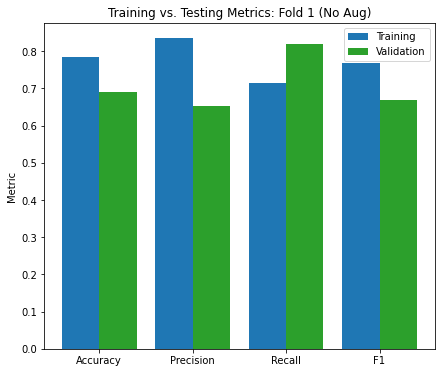

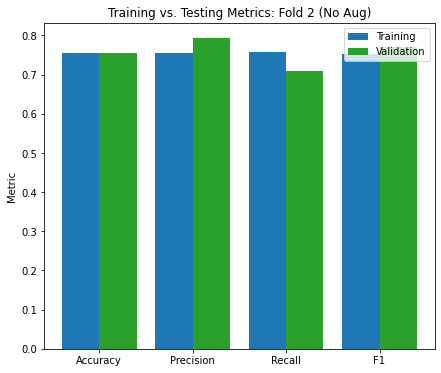

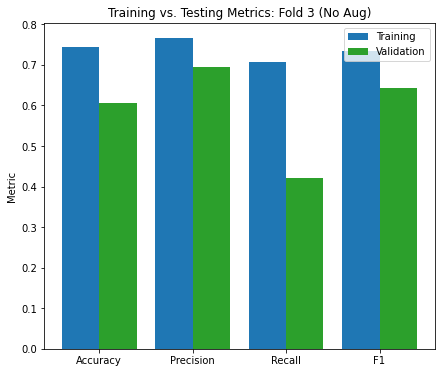

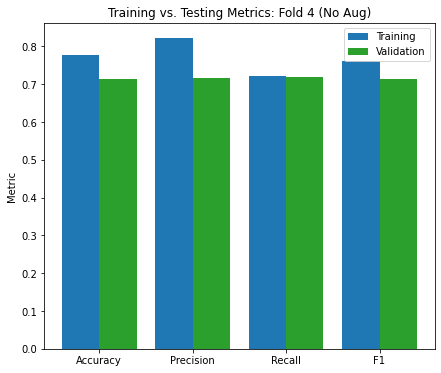

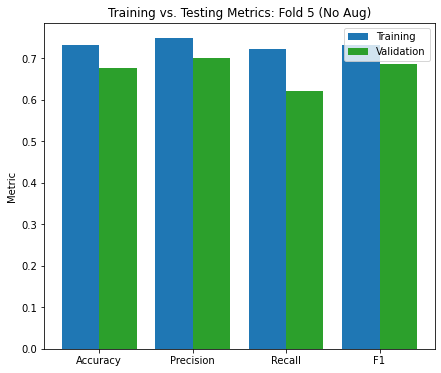

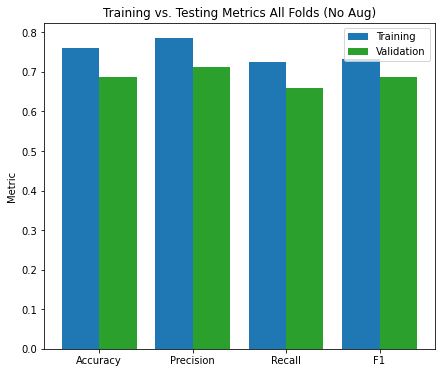

In [47]:
import matplotlib.pyplot as plt
import numpy as np

for FOLD_NUMBER in range(6): 
    
    if FOLD_NUMBER == 5: 
        training_acc = round(METRICS[:, 0].mean(), 3)
        training_precision = round(METRICS[:, 1].mean(), 3)
        training_recall = round(METRICS[:, 2].mean(), 3)
        validation_acc = round(METRICS[:, 3].mean(), 3)
        validation_precision = round(METRICS[:, 4].mean(), 3)
        validation_recall = round(METRICS[:, 5].mean(), 3)

        train_f1 = hmean(training_precision, train_recall)
        val_f1 = hmean(validation_precision, validation_recall)
    
    else : 
        metrics = METRICS_DICT[FOLD_NUMBER]
        training_acc = round(metrics[:, 0].mean(), 3)
        training_precision = round(metrics[:, 1].mean(), 3)
        training_recall = round(metrics[:, 2].mean(), 3)
        validation_acc = round(metrics[:, 3].mean(), 3)
        validation_precision = round(metrics[:, 4].mean(), 3)
        validation_recall = round(metrics[:, 5].mean(), 3)


        training_f1 = hmean(metrics[:, 1], metrics[:, 2]).mean()
        validation_f1 = hmean(metrics[:, 3], metrics[:, 4]).mean()

    labels = ['Accuracy', "Precision", "Recall", "F1"]

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6)
    rects1 = ax.bar(x - width/2, [training_acc, training_precision, training_recall, training_f1], width, label='Training', color = "tab:blue")
    rects2 = ax.bar(x + width/2, [validation_acc, validation_precision, validation_recall, validation_f1], width, label='Validation', color="tab:green")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Metric')
    if FOLD_NUMBER != 5: 
        ax.set_title(f"Training vs. Testing Metrics: Fold {FOLD_NUMBER + 1} (No Aug)")
    else: 
        ax.set_title("Training vs. Testing Metrics All Folds (No Aug)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc="upper right")

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    if FOLD_NUMBER != 5 : 
        plt.savefig(f"balanced_plots/train_vs_test_{FOLD_NUMBER + 1}_naug.png")

    else: 
        plt.savefig("balanced_plots/train_vs_test_all_naug.png")
    plt.show()